In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple, List, Sequence
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, ToPILImage, Normalize
from torch import Tensor
import numpy as np
import multiprocessing as mp
import pandas as pd
from tqdm import tqdm
import logging
from collections import OrderedDict
from matplotlib import pyplot as plt
import seaborn as sns
from torchvision.utils import save_image

## Importing custom modules

In [3]:
from super_image_resolution.utils import (
    split, 
    load,
    dump, 
    make_dirs)
from super_image_resolution.datasets import CustomDataset
from super_image_resolution.transforms import CustomResize
from super_image_resolution.models.unet import UNet
from super_image_resolution.metrics import compute_ssim, compute_psnr
from super_image_resolution.plotting import display_random_output
from super_image_resolution import get_root_path

In [4]:
HPARAMS = pd.read_pickle(
    "/home/mittal.nit/projects/super_image_resolution/"
    f"assets/unet_l1loss_batchnorm48to128/version_2/hparams")

In [5]:
HPARAMS

OrderedDict([('VERBOSE', True),
             ('PROJECT_PATH',
              PosixPath('/home/mittal.nit/projects/super_image_resolution')),
             ('ASSETS_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets'),
             ('DATA_PATH', '/scratch/mittal.nit/faces-spring-2020'),
             ('MODEL_NAME', 'unet_l1loss_batchnorm48to128'),
             ('MODEL_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm48to128'),
             ('WEIGHTS_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm48to128/weights'),
             ('MODEL_WEIGHTS', 'model'),
             ('OPTIM_WEIGHTS', 'optim'),
             ('LR_SCH_WEIGHTS', 'lr_sch'),
             ('VERSION', 2),
             ('EXPERIMENT_VERSION_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm48to128/version_2'),
             ('LOG', 'log'),
             ('HPA

In [6]:
TRAIN_IMAGES_PATH = os.path.join(os.path.dirname(HPARAMS["IMAGES_PATH"]), "train") 
make_dirs(TRAIN_IMAGES_PATH)
TEST_IMAGES_PATH = os.path.join(os.path.dirname(HPARAMS["IMAGES_PATH"]), "test") 
make_dirs(TEST_IMAGES_PATH)

/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm48to128/version_2/images/train already exists
/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm48to128/version_2/images/test already exists


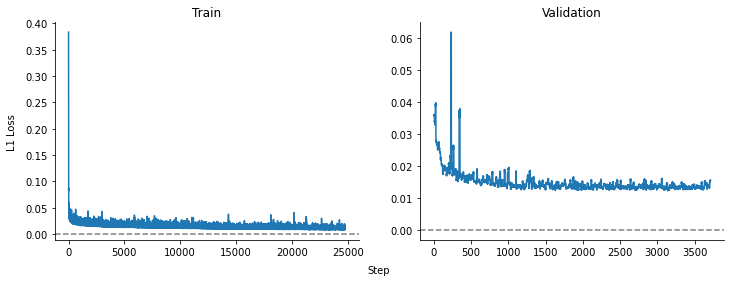

In [7]:
metrics = pd.read_pickle(os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["METRICS"]))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.plot(metrics["train"]["step"])
ax1.axhline(y=0, linestyle="dashed", color="gray")
ax1.set_title("Train")
ax2.plot(metrics["val"]["step"])
ax2.axhline(y=0, linestyle="dashed", color="gray")
ax2.set_title("Validation")
sns.despine(ax=ax1)
fig.text(x=.07, y=.5, s="L1 Loss", va="center", rotation=90)
fig.text(x=.5, y=.01, s="Step", ha="center")
sns.despine(ax=ax2)
# plt.tight_layout()
plt.savefig(os.path.join(TRAIN_IMAGES_PATH, "losses"), dpi=300, bbox_inches="tight")
plt.show()

In [8]:
train_path, _, test_path = split(
    path=HPARAMS["DATA_PATH"], 
    ratios=HPARAMS["SPLIT_RATIOS"],
    seed=HPARAMS["RANDOM_SEED"])

in_transforms = Compose([
    CustomResize(size=48, interpolation=InterpolationMode.BICUBIC), 
    CustomResize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(), 
])
out_transforms = Compose([
    Resize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(),  
])

train_dataset = CustomDataset(
    paths=train_path, in_transforms=in_transforms, out_transforms=out_transforms)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=HPARAMS["TRAIN_BATCH_SIZE"],
    shuffle=True, 
    num_workers=HPARAMS["NUM_WORKERS"])

test_dataset = CustomDataset(
    paths=test_path, in_transforms=in_transforms, out_transforms=out_transforms)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=HPARAMS["TEST_BATCH_SIZE"],
    shuffle=False, 
    num_workers=HPARAMS["NUM_WORKERS"])

In [25]:
X, Y = next(iter(train_loader))
save_image(tensor=X[:5], fp=os.path.join(TRAIN_IMAGES_PATH, "train_sampled_inputs.png"), pad_value=1, padding=10)
save_image(tensor=Y[:5], fp=os.path.join(TRAIN_IMAGES_PATH, "train_sampled_ground_truth_outputs.png"), pad_value=1, padding=10)

## Loading pre-trained model

In [10]:
model = UNet(
    in_channels=HPARAMS["IN_CHANNELS"], 
    out_channels=HPARAMS["OUT_CHANNELS"],
    norm=HPARAMS["NORM"],
    act=HPARAMS["ACTIVATION"])
model.to(HPARAMS["DEVICE"])

UNet(
  (encoder): UNetEncoder(
    (downs): ModuleList(
      (0): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

## Loading pre-trained model

In [11]:
if HPARAMS["MODEL_WEIGHTS"] in os.listdir(HPARAMS["WEIGHTS_PATH"]):
    try:
        model.load_state_dict(torch.load(os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["MODEL_WEIGHTS"])))
        print("Loaded pre-trained model weights")
    except Exception as e:
        print(f"Error: {e}")

Loaded pre-trained model weights


In [12]:
def testing_step(model, X: Tensor, Y: Tensor) -> Tensor:
    """Test step for super-resolution pix-2-pix model."""
    torch.set_grad_enabled(False)
    model.eval()
    Y_hat = HPARAMS["SCALE_Y"] * model(X)
    return Y_hat

In [13]:
## Visualizing training inputs

In [14]:
ssim_in, ssim_out = [], []
psnr_in, psnr_out = [], []


for X, Y in tqdm(test_loader, leave=False, position=True):
    X, Y = X.to(HPARAMS["DEVICE"]), Y.to(HPARAMS["DEVICE"])
    Y_hat = testing_step(model, X, Y)
    X, Y, Y_hat = X.to("cpu"), Y.to("cpu"), Y_hat.to("cpu")
    Y_hat = torch.clamp(Y_hat, 0., 1.)
    
    i, o  = compute_ssim(X, Y, Y_hat)    
    ssim_in += i
    ssim_out += o

    i, o = compute_psnr(X, Y, Y_hat)
    psnr_in += i
    psnr_out += o


                                                  
                                                  
100%|██████████| 2/2 [00:15<00:00,  6.74s/it]
                                             

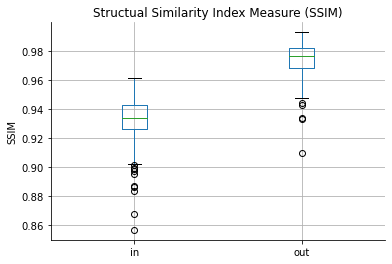

In [15]:
test_metrics = pd.DataFrame(data={
    "ssim_in": ssim_in,
    "ssim_out": ssim_out,
    "psnr_in": psnr_in, 
    "psnr_out": psnr_out})

fig, ax = plt.subplots(figsize=(6, 4))
test_metrics.boxplot(column=["ssim_in", "ssim_out"], ax=ax)
ax.set_title("Structual Similarity Index Measure (SSIM)")
ax.set_xticklabels(["in", "out"])
ax.set_ylabel("SSIM")
sns.despine(ax=ax)
plt.savefig(os.path.join(TEST_IMAGES_PATH, "test_ssim.png"), dpi=300)
plt.show()

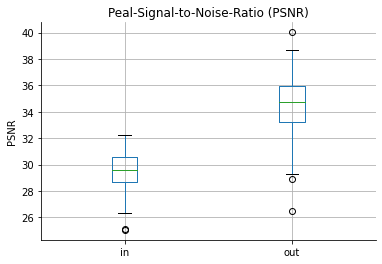

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
test_metrics.boxplot(column=["psnr_in", "psnr_out"], ax=ax)
ax.set_title("Peal-Signal-to-Noise-Ratio (PSNR)")
ax.set_xticklabels(["in", "out"])
ax.set_ylabel("PSNR")
sns.despine(ax=ax)
plt.savefig(os.path.join(TEST_IMAGES_PATH, "test_psnr.png"), dpi=300)
plt.show()

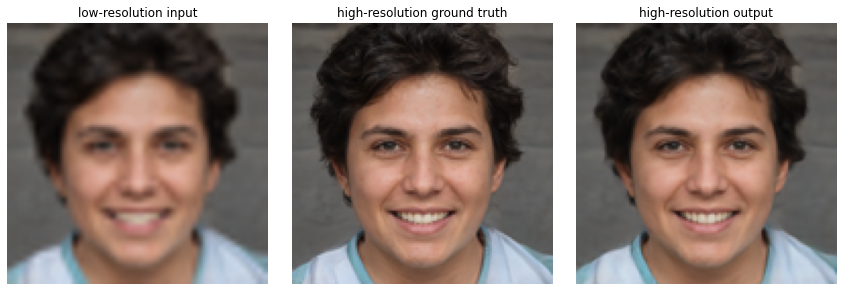

In [17]:
i = 0
display_random_output(X, Y, Y_hat, figsize=(12,4), save_image=True, fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), dpi=500)
i+=1

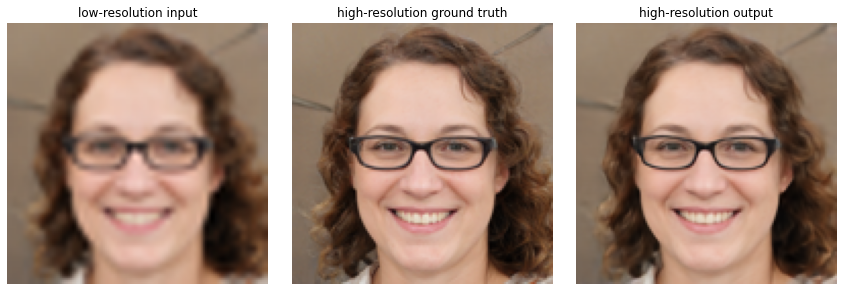

In [18]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

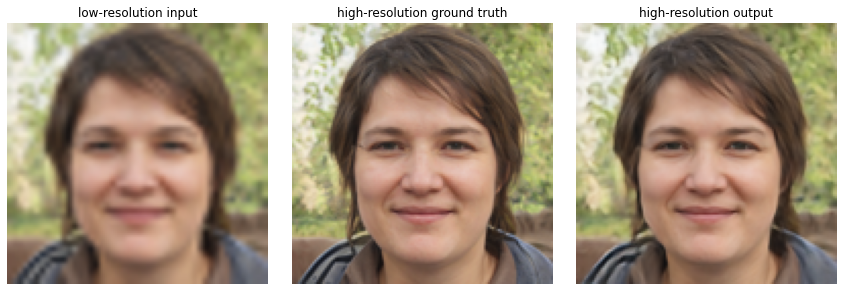

In [19]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

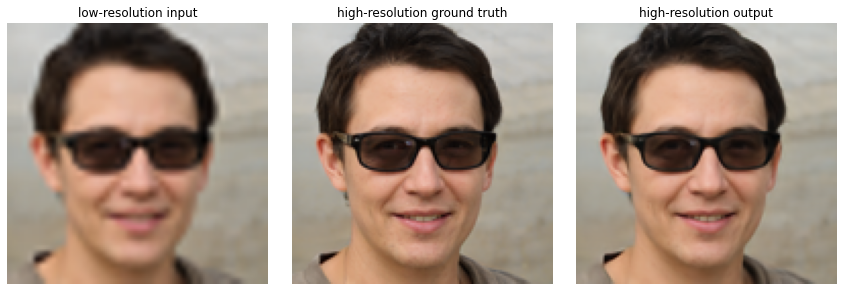

In [20]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

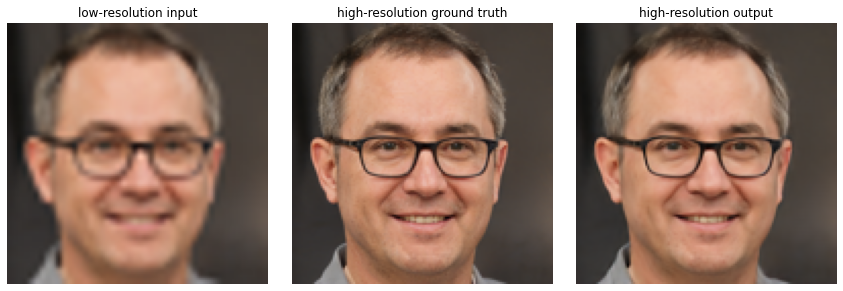

In [21]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

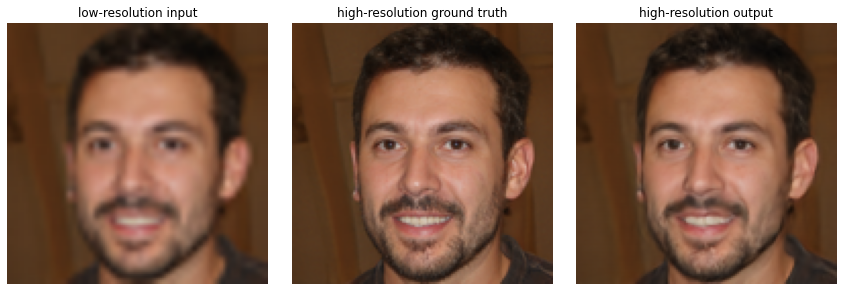

In [22]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

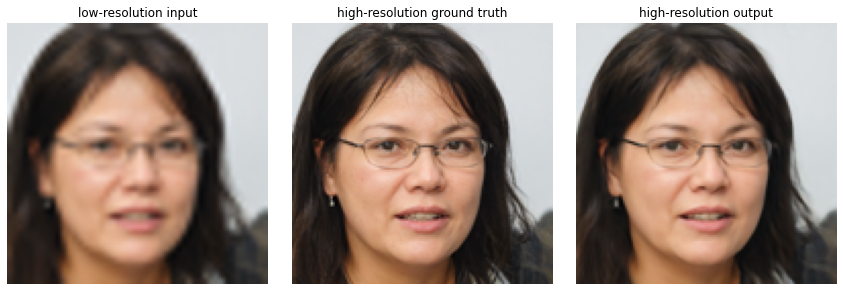

In [23]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1

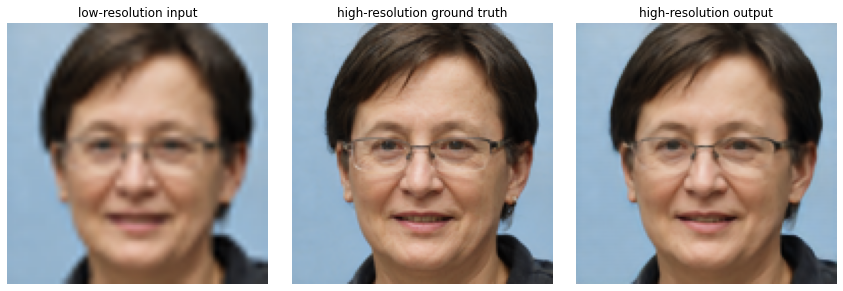

In [24]:
display_random_output(X, Y, Y_hat, 
                      figsize=(12,4), 
                      save_image=True, 
                      fp=os.path.join(TEST_IMAGES_PATH, f"{i}"), 
                      dpi=500)
i+=1